In [ ]:
!pip install transformers datasets timm einops --quiet

In [ ]:
!pip uninstall -y keras tensorflow tensorflow-cpu tensorflow-gpu keras-nightly keras-preprocessing keras-vis


In [ ]:
!pip install --upgrade transformers


In [ ]:
!pip uninstall transformers -y


In [ ]:
!pip install transformers==4.40.2


In [ ]:
!pip install accelerate -U


In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [2]:
import torch
from torchvision import transforms, datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

c:\Users\Lenovo\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = "dataset/"
BATCH_SIZE = 16
NUM_CLASSES = 90
MODEL_NAME = "google/vit-base-patch16-224-in21k"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# 4. Feature Extractor y Transformaciones
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

def transform(example):
    return processor(images=example[0], return_tensors="pt")

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

c:\Users\Lenovo\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# 5. Dataset con torchvision
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform_train)

In [6]:
# 6. Modelo
model = ViTForImageClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [7]:
# 7. Entrenamiento
training_args = TrainingArguments(
    output_dir="./vit_animales",
    evaluation_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    remove_unused_columns=False,
    report_to="none",
)

def collate_fn(batch):
    images, labels = zip(*batch)
    encodings = processor(images=list(images), return_tensors="pt")
    encodings["labels"] = torch.tensor(labels)
    return encodings

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
)

trainer.train()

  1%|          | 10/1350 [00:09<17:56,  1.24it/s]

{'loss': 4.5113, 'grad_norm': 0.9562236070632935, 'learning_rate': 4.962962962962963e-05, 'epoch': 0.04}


  1%|▏         | 20/1350 [00:16<16:22,  1.35it/s]

{'loss': 4.5114, 'grad_norm': 0.8585706353187561, 'learning_rate': 4.925925925925926e-05, 'epoch': 0.07}


  2%|▏         | 30/1350 [00:24<16:26,  1.34it/s]

{'loss': 4.5142, 'grad_norm': 0.8449008464813232, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.11}


  3%|▎         | 40/1350 [00:31<16:25,  1.33it/s]

{'loss': 4.496, 'grad_norm': 0.9243622422218323, 'learning_rate': 4.851851851851852e-05, 'epoch': 0.15}


  4%|▎         | 50/1350 [00:39<16:14,  1.33it/s]

{'loss': 4.5028, 'grad_norm': 1.010651707649231, 'learning_rate': 4.814814814814815e-05, 'epoch': 0.19}


  4%|▍         | 60/1350 [00:46<16:22,  1.31it/s]

{'loss': 4.5112, 'grad_norm': 0.9871514439582825, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.22}


  5%|▌         | 70/1350 [00:54<16:04,  1.33it/s]

{'loss': 4.4963, 'grad_norm': 0.8844282627105713, 'learning_rate': 4.740740740740741e-05, 'epoch': 0.26}


  6%|▌         | 80/1350 [01:01<15:40,  1.35it/s]

{'loss': 4.5273, 'grad_norm': 0.7638373374938965, 'learning_rate': 4.703703703703704e-05, 'epoch': 0.3}


  7%|▋         | 90/1350 [01:09<15:57,  1.32it/s]

{'loss': 4.5088, 'grad_norm': 0.7102782726287842, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.33}


  7%|▋         | 100/1350 [01:17<16:37,  1.25it/s]

{'loss': 4.5062, 'grad_norm': 0.6424890756607056, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.37}


  8%|▊         | 110/1350 [01:25<17:19,  1.19it/s]

{'loss': 4.5123, 'grad_norm': 0.666974663734436, 'learning_rate': 4.592592592592593e-05, 'epoch': 0.41}


  9%|▉         | 120/1350 [01:33<15:53,  1.29it/s]

{'loss': 4.5076, 'grad_norm': 0.5801838040351868, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.44}


 10%|▉         | 130/1350 [01:40<15:41,  1.30it/s]

{'loss': 4.5017, 'grad_norm': 0.5534734129905701, 'learning_rate': 4.518518518518519e-05, 'epoch': 0.48}


 10%|█         | 140/1350 [01:48<15:55,  1.27it/s]

{'loss': 4.5034, 'grad_norm': 0.6143471002578735, 'learning_rate': 4.481481481481482e-05, 'epoch': 0.52}


 11%|█         | 150/1350 [01:56<15:54,  1.26it/s]

{'loss': 4.5061, 'grad_norm': 0.585290253162384, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.56}


 12%|█▏        | 160/1350 [02:04<14:57,  1.33it/s]

{'loss': 4.5117, 'grad_norm': 0.559522807598114, 'learning_rate': 4.4074074074074076e-05, 'epoch': 0.59}


 13%|█▎        | 170/1350 [02:11<14:50,  1.33it/s]

{'loss': 4.5191, 'grad_norm': 0.5356360673904419, 'learning_rate': 4.3703703703703705e-05, 'epoch': 0.63}


 13%|█▎        | 180/1350 [02:19<14:27,  1.35it/s]

{'loss': 4.5008, 'grad_norm': 0.5365258455276489, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.67}


 14%|█▍        | 190/1350 [02:27<15:12,  1.27it/s]

{'loss': 4.5036, 'grad_norm': 0.5546309947967529, 'learning_rate': 4.296296296296296e-05, 'epoch': 0.7}


 15%|█▍        | 200/1350 [02:34<14:26,  1.33it/s]

{'loss': 4.5051, 'grad_norm': 0.5558744668960571, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.74}


 16%|█▌        | 210/1350 [02:42<14:53,  1.28it/s]

{'loss': 4.5105, 'grad_norm': 0.5123218297958374, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.78}


 16%|█▋        | 220/1350 [02:50<15:19,  1.23it/s]

{'loss': 4.511, 'grad_norm': 0.5596892237663269, 'learning_rate': 4.185185185185185e-05, 'epoch': 0.81}


 17%|█▋        | 230/1350 [02:57<14:26,  1.29it/s]

{'loss': 4.5084, 'grad_norm': 0.471387654542923, 'learning_rate': 4.148148148148148e-05, 'epoch': 0.85}


 18%|█▊        | 240/1350 [03:05<14:10,  1.31it/s]

{'loss': 4.5038, 'grad_norm': 0.5531173348426819, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.89}


 19%|█▊        | 250/1350 [03:13<13:48,  1.33it/s]

{'loss': 4.5072, 'grad_norm': 0.5033326148986816, 'learning_rate': 4.074074074074074e-05, 'epoch': 0.93}


 19%|█▉        | 260/1350 [03:21<14:31,  1.25it/s]

{'loss': 4.5103, 'grad_norm': 0.5050350427627563, 'learning_rate': 4.0370370370370374e-05, 'epoch': 0.96}


 20%|██        | 270/1350 [03:28<11:59,  1.50it/s]

{'loss': 4.5084, 'grad_norm': 0.4959891736507416, 'learning_rate': 4e-05, 'epoch': 1.0}


                                                  
 20%|██        | 270/1350 [03:59<11:59,  1.50it/s]

{'eval_loss': 4.500182151794434, 'eval_runtime': 30.5313, 'eval_samples_per_second': 35.373, 'eval_steps_per_second': 2.227, 'epoch': 1.0}


 21%|██        | 280/1350 [04:07<18:32,  1.04s/it]  

{'loss': 4.5015, 'grad_norm': 0.4942033290863037, 'learning_rate': 3.962962962962963e-05, 'epoch': 1.04}


 21%|██▏       | 290/1350 [04:13<11:28,  1.54it/s]

{'loss': 4.5026, 'grad_norm': 0.5240698456764221, 'learning_rate': 3.925925925925926e-05, 'epoch': 1.07}


 22%|██▏       | 300/1350 [04:20<11:16,  1.55it/s]

{'loss': 4.5012, 'grad_norm': 0.5886160135269165, 'learning_rate': 3.888888888888889e-05, 'epoch': 1.11}


 23%|██▎       | 310/1350 [04:26<11:38,  1.49it/s]

{'loss': 4.5025, 'grad_norm': 0.5719890594482422, 'learning_rate': 3.851851851851852e-05, 'epoch': 1.15}


 24%|██▎       | 320/1350 [04:33<11:11,  1.53it/s]

{'loss': 4.4988, 'grad_norm': 0.4927033483982086, 'learning_rate': 3.814814814814815e-05, 'epoch': 1.19}


 24%|██▍       | 330/1350 [04:40<10:56,  1.55it/s]

{'loss': 4.5028, 'grad_norm': 0.4949144721031189, 'learning_rate': 3.777777777777778e-05, 'epoch': 1.22}


 25%|██▌       | 340/1350 [04:46<11:23,  1.48it/s]

{'loss': 4.5016, 'grad_norm': 0.5179809927940369, 'learning_rate': 3.740740740740741e-05, 'epoch': 1.26}


 26%|██▌       | 350/1350 [04:53<11:28,  1.45it/s]

{'loss': 4.505, 'grad_norm': 0.5088649392127991, 'learning_rate': 3.7037037037037037e-05, 'epoch': 1.3}


 27%|██▋       | 360/1350 [04:59<10:46,  1.53it/s]

{'loss': 4.5061, 'grad_norm': 0.52507483959198, 'learning_rate': 3.6666666666666666e-05, 'epoch': 1.33}


 27%|██▋       | 370/1350 [05:06<10:32,  1.55it/s]

{'loss': 4.5057, 'grad_norm': 0.4920429587364197, 'learning_rate': 3.62962962962963e-05, 'epoch': 1.37}


 28%|██▊       | 380/1350 [05:12<10:26,  1.55it/s]

{'loss': 4.503, 'grad_norm': 0.4548654556274414, 'learning_rate': 3.592592592592593e-05, 'epoch': 1.41}


 29%|██▉       | 390/1350 [05:19<10:45,  1.49it/s]

{'loss': 4.5033, 'grad_norm': 0.5258389115333557, 'learning_rate': 3.555555555555556e-05, 'epoch': 1.44}


 30%|██▉       | 400/1350 [05:26<10:21,  1.53it/s]

{'loss': 4.5017, 'grad_norm': 0.5544663667678833, 'learning_rate': 3.518518518518519e-05, 'epoch': 1.48}


 30%|███       | 410/1350 [05:32<10:23,  1.51it/s]

{'loss': 4.5041, 'grad_norm': 0.5601581335067749, 'learning_rate': 3.481481481481482e-05, 'epoch': 1.52}


 31%|███       | 420/1350 [05:39<10:41,  1.45it/s]

{'loss': 4.5028, 'grad_norm': 0.5500606894493103, 'learning_rate': 3.444444444444445e-05, 'epoch': 1.56}


 32%|███▏      | 430/1350 [05:46<10:26,  1.47it/s]

{'loss': 4.5047, 'grad_norm': 0.48980513215065, 'learning_rate': 3.4074074074074077e-05, 'epoch': 1.59}


 33%|███▎      | 440/1350 [05:53<09:42,  1.56it/s]

{'loss': 4.5051, 'grad_norm': 0.4679275155067444, 'learning_rate': 3.3703703703703706e-05, 'epoch': 1.63}


 33%|███▎      | 450/1350 [05:59<10:12,  1.47it/s]

{'loss': 4.5063, 'grad_norm': 0.5507869124412537, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.67}


 34%|███▍      | 460/1350 [06:06<09:24,  1.58it/s]

{'loss': 4.5032, 'grad_norm': 0.5702100396156311, 'learning_rate': 3.2962962962962964e-05, 'epoch': 1.7}


 35%|███▍      | 470/1350 [06:13<10:30,  1.40it/s]

{'loss': 4.5067, 'grad_norm': 0.5743423104286194, 'learning_rate': 3.25925925925926e-05, 'epoch': 1.74}


 36%|███▌      | 480/1350 [06:19<09:30,  1.53it/s]

{'loss': 4.5094, 'grad_norm': 0.49947434663772583, 'learning_rate': 3.222222222222223e-05, 'epoch': 1.78}


 36%|███▋      | 490/1350 [06:26<09:10,  1.56it/s]

{'loss': 4.5028, 'grad_norm': 0.4444058835506439, 'learning_rate': 3.185185185185185e-05, 'epoch': 1.81}


 37%|███▋      | 500/1350 [06:32<09:24,  1.50it/s]

{'loss': 4.4992, 'grad_norm': 0.49021345376968384, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.85}


 38%|███▊      | 510/1350 [06:39<09:23,  1.49it/s]

{'loss': 4.5089, 'grad_norm': 0.4729512333869934, 'learning_rate': 3.111111111111111e-05, 'epoch': 1.89}


 39%|███▊      | 520/1350 [06:46<09:24,  1.47it/s]

{'loss': 4.4997, 'grad_norm': 0.4823577105998993, 'learning_rate': 3.074074074074074e-05, 'epoch': 1.93}


 39%|███▉      | 530/1350 [06:53<08:50,  1.55it/s]

{'loss': 4.5083, 'grad_norm': 0.45178160071372986, 'learning_rate': 3.037037037037037e-05, 'epoch': 1.96}


 40%|████      | 540/1350 [06:59<08:17,  1.63it/s]

{'loss': 4.5099, 'grad_norm': 0.4370918273925781, 'learning_rate': 3e-05, 'epoch': 2.0}


                                                  
 40%|████      | 540/1350 [07:23<08:17,  1.63it/s]

{'eval_loss': 4.5000481605529785, 'eval_runtime': 23.6062, 'eval_samples_per_second': 45.751, 'eval_steps_per_second': 2.881, 'epoch': 2.0}


 41%|████      | 550/1350 [07:30<12:31,  1.06it/s]  

{'loss': 4.5, 'grad_norm': 0.519666850566864, 'learning_rate': 2.962962962962963e-05, 'epoch': 2.04}


 41%|████▏     | 560/1350 [07:37<08:57,  1.47it/s]

{'loss': 4.5004, 'grad_norm': 0.45378217101097107, 'learning_rate': 2.925925925925926e-05, 'epoch': 2.07}


 42%|████▏     | 570/1350 [07:44<08:37,  1.51it/s]

{'loss': 4.4974, 'grad_norm': 0.4932536482810974, 'learning_rate': 2.8888888888888888e-05, 'epoch': 2.11}


 43%|████▎     | 580/1350 [07:51<08:35,  1.49it/s]

{'loss': 4.5035, 'grad_norm': 0.47943997383117676, 'learning_rate': 2.851851851851852e-05, 'epoch': 2.15}


 44%|████▎     | 590/1350 [07:57<07:54,  1.60it/s]

{'loss': 4.5034, 'grad_norm': 0.48337382078170776, 'learning_rate': 2.814814814814815e-05, 'epoch': 2.19}


 44%|████▍     | 600/1350 [08:04<08:32,  1.46it/s]

{'loss': 4.4993, 'grad_norm': 0.4751507639884949, 'learning_rate': 2.777777777777778e-05, 'epoch': 2.22}


 45%|████▌     | 610/1350 [08:10<08:04,  1.53it/s]

{'loss': 4.5018, 'grad_norm': 0.6007166504859924, 'learning_rate': 2.7407407407407408e-05, 'epoch': 2.26}


 46%|████▌     | 620/1350 [08:17<08:13,  1.48it/s]

{'loss': 4.5012, 'grad_norm': 0.5394887924194336, 'learning_rate': 2.7037037037037037e-05, 'epoch': 2.3}


 47%|████▋     | 630/1350 [08:23<08:11,  1.47it/s]

{'loss': 4.5039, 'grad_norm': 0.47969141602516174, 'learning_rate': 2.6666666666666667e-05, 'epoch': 2.33}


 47%|████▋     | 640/1350 [08:30<07:44,  1.53it/s]

{'loss': 4.5021, 'grad_norm': 0.5026612281799316, 'learning_rate': 2.6296296296296296e-05, 'epoch': 2.37}


 48%|████▊     | 650/1350 [08:37<07:39,  1.52it/s]

{'loss': 4.4997, 'grad_norm': 0.47685104608535767, 'learning_rate': 2.5925925925925925e-05, 'epoch': 2.41}


 49%|████▉     | 660/1350 [08:44<08:01,  1.43it/s]

{'loss': 4.5052, 'grad_norm': 0.4973064064979553, 'learning_rate': 2.5555555555555554e-05, 'epoch': 2.44}


 50%|████▉     | 670/1350 [08:50<07:17,  1.56it/s]

{'loss': 4.5032, 'grad_norm': 0.5028828382492065, 'learning_rate': 2.5185185185185183e-05, 'epoch': 2.48}


 50%|█████     | 680/1350 [08:57<07:15,  1.54it/s]

{'loss': 4.5016, 'grad_norm': 0.4781235456466675, 'learning_rate': 2.4814814814814816e-05, 'epoch': 2.52}


 51%|█████     | 690/1350 [09:04<07:19,  1.50it/s]

{'loss': 4.4984, 'grad_norm': 0.5708016157150269, 'learning_rate': 2.4444444444444445e-05, 'epoch': 2.56}


 52%|█████▏    | 700/1350 [09:10<07:05,  1.53it/s]

{'loss': 4.5016, 'grad_norm': 0.49113792181015015, 'learning_rate': 2.4074074074074074e-05, 'epoch': 2.59}


 53%|█████▎    | 710/1350 [09:17<07:01,  1.52it/s]

{'loss': 4.5068, 'grad_norm': 0.47227564454078674, 'learning_rate': 2.3703703703703707e-05, 'epoch': 2.63}


 53%|█████▎    | 720/1350 [09:23<07:04,  1.48it/s]

{'loss': 4.5032, 'grad_norm': 0.47834232449531555, 'learning_rate': 2.3333333333333336e-05, 'epoch': 2.67}


 54%|█████▍    | 730/1350 [09:30<06:41,  1.54it/s]

{'loss': 4.5021, 'grad_norm': 0.48386624455451965, 'learning_rate': 2.2962962962962965e-05, 'epoch': 2.7}


 55%|█████▍    | 740/1350 [09:37<06:48,  1.49it/s]

{'loss': 4.5057, 'grad_norm': 0.5106997489929199, 'learning_rate': 2.2592592592592594e-05, 'epoch': 2.74}


 56%|█████▌    | 750/1350 [09:44<06:42,  1.49it/s]

{'loss': 4.5036, 'grad_norm': 0.5201141834259033, 'learning_rate': 2.2222222222222223e-05, 'epoch': 2.78}


 56%|█████▋    | 760/1350 [09:50<06:56,  1.42it/s]

{'loss': 4.5032, 'grad_norm': 0.5460297465324402, 'learning_rate': 2.1851851851851852e-05, 'epoch': 2.81}


 57%|█████▋    | 770/1350 [09:57<06:25,  1.51it/s]

{'loss': 4.5053, 'grad_norm': 0.47917982935905457, 'learning_rate': 2.148148148148148e-05, 'epoch': 2.85}


 58%|█████▊    | 780/1350 [10:04<06:23,  1.49it/s]

{'loss': 4.5038, 'grad_norm': 0.4657255709171295, 'learning_rate': 2.111111111111111e-05, 'epoch': 2.89}


 59%|█████▊    | 790/1350 [10:10<06:12,  1.50it/s]

{'loss': 4.5041, 'grad_norm': 0.4575391113758087, 'learning_rate': 2.074074074074074e-05, 'epoch': 2.93}


 59%|█████▉    | 800/1350 [10:17<05:58,  1.53it/s]

{'loss': 4.5046, 'grad_norm': 0.5198403596878052, 'learning_rate': 2.037037037037037e-05, 'epoch': 2.96}


 60%|██████    | 810/1350 [10:23<05:24,  1.67it/s]

{'loss': 4.5046, 'grad_norm': 0.41979867219924927, 'learning_rate': 2e-05, 'epoch': 3.0}


                                                  
 60%|██████    | 810/1350 [10:47<05:24,  1.67it/s]

{'eval_loss': 4.499922275543213, 'eval_runtime': 23.7816, 'eval_samples_per_second': 45.413, 'eval_steps_per_second': 2.859, 'epoch': 3.0}


 61%|██████    | 820/1350 [10:55<08:30,  1.04it/s]  

{'loss': 4.5001, 'grad_norm': 0.48838576674461365, 'learning_rate': 1.962962962962963e-05, 'epoch': 3.04}


 61%|██████▏   | 830/1350 [11:02<05:49,  1.49it/s]

{'loss': 4.5023, 'grad_norm': 0.5035366415977478, 'learning_rate': 1.925925925925926e-05, 'epoch': 3.07}


 62%|██████▏   | 840/1350 [11:09<05:44,  1.48it/s]

{'loss': 4.4998, 'grad_norm': 0.5002865791320801, 'learning_rate': 1.888888888888889e-05, 'epoch': 3.11}


 63%|██████▎   | 850/1350 [11:15<05:37,  1.48it/s]

{'loss': 4.5037, 'grad_norm': 0.4522261321544647, 'learning_rate': 1.8518518518518518e-05, 'epoch': 3.15}


 64%|██████▎   | 860/1350 [11:22<05:17,  1.54it/s]

{'loss': 4.5004, 'grad_norm': 0.5097435116767883, 'learning_rate': 1.814814814814815e-05, 'epoch': 3.19}


 64%|██████▍   | 870/1350 [11:29<05:29,  1.46it/s]

{'loss': 4.4983, 'grad_norm': 0.4540969729423523, 'learning_rate': 1.777777777777778e-05, 'epoch': 3.22}


 65%|██████▌   | 880/1350 [11:36<05:27,  1.43it/s]

{'loss': 4.5008, 'grad_norm': 0.5493395328521729, 'learning_rate': 1.740740740740741e-05, 'epoch': 3.26}


 66%|██████▌   | 890/1350 [11:43<05:08,  1.49it/s]

{'loss': 4.5016, 'grad_norm': 0.48864126205444336, 'learning_rate': 1.7037037037037038e-05, 'epoch': 3.3}


 67%|██████▋   | 900/1350 [11:49<04:52,  1.54it/s]

{'loss': 4.5013, 'grad_norm': 0.5478765964508057, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}


 67%|██████▋   | 910/1350 [11:56<04:53,  1.50it/s]

{'loss': 4.5042, 'grad_norm': 0.4998348653316498, 'learning_rate': 1.62962962962963e-05, 'epoch': 3.37}


 68%|██████▊   | 920/1350 [12:03<04:44,  1.51it/s]

{'loss': 4.501, 'grad_norm': 0.47095391154289246, 'learning_rate': 1.5925925925925926e-05, 'epoch': 3.41}


 69%|██████▉   | 930/1350 [12:09<04:31,  1.55it/s]

{'loss': 4.5014, 'grad_norm': 0.42510369420051575, 'learning_rate': 1.5555555555555555e-05, 'epoch': 3.44}


 70%|██████▉   | 940/1350 [12:16<04:45,  1.44it/s]

{'loss': 4.502, 'grad_norm': 0.5008190274238586, 'learning_rate': 1.5185185185185186e-05, 'epoch': 3.48}


 70%|███████   | 950/1350 [12:23<04:34,  1.46it/s]

{'loss': 4.5012, 'grad_norm': 0.42206618189811707, 'learning_rate': 1.4814814814814815e-05, 'epoch': 3.52}


 71%|███████   | 960/1350 [12:30<04:28,  1.45it/s]

{'loss': 4.5016, 'grad_norm': 0.48039212822914124, 'learning_rate': 1.4444444444444444e-05, 'epoch': 3.56}


 72%|███████▏  | 970/1350 [12:37<04:08,  1.53it/s]

{'loss': 4.5016, 'grad_norm': 0.4362257421016693, 'learning_rate': 1.4074074074074075e-05, 'epoch': 3.59}


 73%|███████▎  | 980/1350 [12:43<04:03,  1.52it/s]

{'loss': 4.5007, 'grad_norm': 0.49281683564186096, 'learning_rate': 1.3703703703703704e-05, 'epoch': 3.63}


 73%|███████▎  | 990/1350 [12:50<03:54,  1.54it/s]

{'loss': 4.5037, 'grad_norm': 0.4713204503059387, 'learning_rate': 1.3333333333333333e-05, 'epoch': 3.67}


 74%|███████▍  | 1000/1350 [12:57<04:02,  1.44it/s]

{'loss': 4.5016, 'grad_norm': 0.5311527848243713, 'learning_rate': 1.2962962962962962e-05, 'epoch': 3.7}


 75%|███████▍  | 1010/1350 [13:03<03:50,  1.48it/s]

{'loss': 4.5024, 'grad_norm': 0.4518832862377167, 'learning_rate': 1.2592592592592592e-05, 'epoch': 3.74}


 76%|███████▌  | 1020/1350 [13:10<03:43,  1.47it/s]

{'loss': 4.5009, 'grad_norm': 0.4698091149330139, 'learning_rate': 1.2222222222222222e-05, 'epoch': 3.78}


 76%|███████▋  | 1030/1350 [13:16<03:24,  1.56it/s]

{'loss': 4.5018, 'grad_norm': 0.47274142503738403, 'learning_rate': 1.1851851851851853e-05, 'epoch': 3.81}


 77%|███████▋  | 1040/1350 [13:23<03:38,  1.42it/s]

{'loss': 4.5035, 'grad_norm': 0.5004698634147644, 'learning_rate': 1.1481481481481482e-05, 'epoch': 3.85}


 78%|███████▊  | 1050/1350 [13:30<03:20,  1.50it/s]

{'loss': 4.5014, 'grad_norm': 0.4769676923751831, 'learning_rate': 1.1111111111111112e-05, 'epoch': 3.89}


 79%|███████▊  | 1060/1350 [13:36<03:13,  1.50it/s]

{'loss': 4.5026, 'grad_norm': 0.48006144165992737, 'learning_rate': 1.074074074074074e-05, 'epoch': 3.93}


 79%|███████▉  | 1070/1350 [13:43<03:18,  1.41it/s]

{'loss': 4.5019, 'grad_norm': 0.5065310001373291, 'learning_rate': 1.037037037037037e-05, 'epoch': 3.96}


 80%|████████  | 1080/1350 [13:50<02:41,  1.67it/s]

{'loss': 4.5034, 'grad_norm': 0.467630535364151, 'learning_rate': 1e-05, 'epoch': 4.0}


                                                   
 80%|████████  | 1080/1350 [14:13<02:41,  1.67it/s]

{'eval_loss': 4.49989128112793, 'eval_runtime': 23.075, 'eval_samples_per_second': 46.804, 'eval_steps_per_second': 2.947, 'epoch': 4.0}


 81%|████████  | 1090/1350 [14:21<04:08,  1.05it/s]

{'loss': 4.4997, 'grad_norm': 0.46172159910202026, 'learning_rate': 9.62962962962963e-06, 'epoch': 4.04}


 81%|████████▏ | 1100/1350 [14:28<02:47,  1.50it/s]

{'loss': 4.5001, 'grad_norm': 0.5025491714477539, 'learning_rate': 9.259259259259259e-06, 'epoch': 4.07}


 82%|████████▏ | 1110/1350 [14:34<02:32,  1.57it/s]

{'loss': 4.5, 'grad_norm': 0.43596482276916504, 'learning_rate': 8.88888888888889e-06, 'epoch': 4.11}


 83%|████████▎ | 1120/1350 [14:41<02:30,  1.53it/s]

{'loss': 4.4989, 'grad_norm': 0.49146246910095215, 'learning_rate': 8.518518518518519e-06, 'epoch': 4.15}


 84%|████████▎ | 1130/1350 [14:48<02:27,  1.49it/s]

{'loss': 4.4997, 'grad_norm': 0.44080856442451477, 'learning_rate': 8.14814814814815e-06, 'epoch': 4.19}


 84%|████████▍ | 1140/1350 [14:54<02:16,  1.54it/s]

{'loss': 4.4999, 'grad_norm': 0.44910717010498047, 'learning_rate': 7.777777777777777e-06, 'epoch': 4.22}


 85%|████████▌ | 1150/1350 [15:01<02:14,  1.48it/s]

{'loss': 4.4997, 'grad_norm': 0.4970763623714447, 'learning_rate': 7.4074074074074075e-06, 'epoch': 4.26}


 86%|████████▌ | 1160/1350 [15:07<02:01,  1.56it/s]

{'loss': 4.5018, 'grad_norm': 0.5059677958488464, 'learning_rate': 7.0370370370370375e-06, 'epoch': 4.3}


 87%|████████▋ | 1170/1350 [15:14<01:56,  1.54it/s]

{'loss': 4.4963, 'grad_norm': 0.42066654562950134, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.33}


 87%|████████▋ | 1180/1350 [15:20<01:50,  1.53it/s]

{'loss': 4.5024, 'grad_norm': 0.5345383286476135, 'learning_rate': 6.296296296296296e-06, 'epoch': 4.37}


 88%|████████▊ | 1190/1350 [15:27<01:45,  1.51it/s]

{'loss': 4.5006, 'grad_norm': 0.42226412892341614, 'learning_rate': 5.925925925925927e-06, 'epoch': 4.41}


 89%|████████▉ | 1200/1350 [15:33<01:36,  1.55it/s]

{'loss': 4.503, 'grad_norm': 0.4509904682636261, 'learning_rate': 5.555555555555556e-06, 'epoch': 4.44}


 90%|████████▉ | 1210/1350 [15:40<01:31,  1.52it/s]

{'loss': 4.5025, 'grad_norm': 0.490961492061615, 'learning_rate': 5.185185185185185e-06, 'epoch': 4.48}


 90%|█████████ | 1220/1350 [15:46<01:25,  1.52it/s]

{'loss': 4.5006, 'grad_norm': 0.494236558675766, 'learning_rate': 4.814814814814815e-06, 'epoch': 4.52}


 91%|█████████ | 1230/1350 [15:53<01:22,  1.46it/s]

{'loss': 4.4989, 'grad_norm': 0.49636906385421753, 'learning_rate': 4.444444444444445e-06, 'epoch': 4.56}


 92%|█████████▏| 1240/1350 [15:59<01:09,  1.58it/s]

{'loss': 4.4998, 'grad_norm': 0.48441359400749207, 'learning_rate': 4.074074074074075e-06, 'epoch': 4.59}


 93%|█████████▎| 1250/1350 [16:06<01:03,  1.58it/s]

{'loss': 4.5016, 'grad_norm': 0.4934420585632324, 'learning_rate': 3.7037037037037037e-06, 'epoch': 4.63}


 93%|█████████▎| 1260/1350 [16:13<00:57,  1.57it/s]

{'loss': 4.5015, 'grad_norm': 0.41628003120422363, 'learning_rate': 3.3333333333333333e-06, 'epoch': 4.67}


 94%|█████████▍| 1270/1350 [16:19<00:52,  1.52it/s]

{'loss': 4.5014, 'grad_norm': 0.5313355922698975, 'learning_rate': 2.9629629629629633e-06, 'epoch': 4.7}


 95%|█████████▍| 1280/1350 [16:25<00:46,  1.49it/s]

{'loss': 4.5006, 'grad_norm': 0.470122754573822, 'learning_rate': 2.5925925925925925e-06, 'epoch': 4.74}


 96%|█████████▌| 1290/1350 [16:32<00:38,  1.56it/s]

{'loss': 4.4999, 'grad_norm': 0.45576581358909607, 'learning_rate': 2.2222222222222225e-06, 'epoch': 4.78}


 96%|█████████▋| 1300/1350 [16:38<00:32,  1.56it/s]

{'loss': 4.5031, 'grad_norm': 0.4831589460372925, 'learning_rate': 1.8518518518518519e-06, 'epoch': 4.81}


 97%|█████████▋| 1310/1350 [16:45<00:25,  1.54it/s]

{'loss': 4.4998, 'grad_norm': 0.4786911606788635, 'learning_rate': 1.4814814814814817e-06, 'epoch': 4.85}


 98%|█████████▊| 1320/1350 [16:52<00:21,  1.39it/s]

{'loss': 4.5034, 'grad_norm': 0.48802798986434937, 'learning_rate': 1.1111111111111112e-06, 'epoch': 4.89}


 99%|█████████▊| 1330/1350 [16:59<00:14,  1.43it/s]

{'loss': 4.5017, 'grad_norm': 0.4675961434841156, 'learning_rate': 7.407407407407408e-07, 'epoch': 4.93}


 99%|█████████▉| 1340/1350 [17:06<00:06,  1.50it/s]

{'loss': 4.5013, 'grad_norm': 0.4319494664669037, 'learning_rate': 3.703703703703704e-07, 'epoch': 4.96}


100%|██████████| 1350/1350 [17:12<00:00,  1.68it/s]

{'loss': 4.5012, 'grad_norm': 0.4640175402164459, 'learning_rate': 0.0, 'epoch': 5.0}


                                                   
100%|██████████| 1350/1350 [17:35<00:00,  1.68it/s]

{'eval_loss': 4.499917507171631, 'eval_runtime': 23.1079, 'eval_samples_per_second': 46.737, 'eval_steps_per_second': 2.943, 'epoch': 5.0}


100%|██████████| 1350/1350 [17:37<00:00,  1.28it/s]

{'train_runtime': 1057.2016, 'train_samples_per_second': 20.431, 'train_steps_per_second': 1.277, 'train_loss': 4.503386880380136, 'epoch': 5.0}


TrainOutput(global_step=1350, training_loss=4.503386880380136, metrics={'train_runtime': 1057.2016, 'train_samples_per_second': 20.431, 'train_steps_per_second': 1.277, 'total_flos': 1.6751471500689408e+18, 'train_loss': 4.503386880380136, 'epoch': 5.0})

In [12]:
def predict_class(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    class_name = train_dataset.classes[predicted_class]
    print(f"🔍 Imagen clasificada como: {class_name}")
    return class_name


In [14]:
predict_class("dataset/train/coyote/0ff564b311.jpg")


🔍 Imagen clasificada como: shark


'shark'

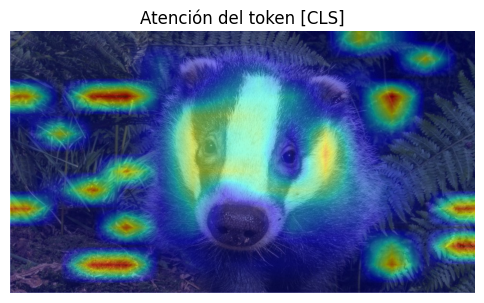

In [17]:
# 8. Visualización de atención (sobre una imagen del val set)
def show_attention(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions  # (layer, batch, head, token, token)
    attn = attentions[-1]  # última capa
    attn = attn[0].mean(0)[0, 1:]  # atención del token CLS hacia los patches
    grid_size = int(attn.size(0) ** 0.5)
    attn = attn.reshape(grid_size, grid_size).detach().cpu().numpy()
    attn = cv2.resize(attn, image.size)
    attn = (attn - attn.min()) / (attn.max() - attn.min())

    # Mostrar imagen y atención superpuesta
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.imshow(attn, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Atención del token [CLS]")
    plt.show()

# Ejemplo de uso:
show_attention(model, "dataset/val/badger/14d27983c0.jpg")